# miRdeep 2

We selected only the miRNA filtered from miRtrace using a python script (header RNA_type = miRNA)

The formated file is called: 317893_S5_R1_001.only_miRNA_formated.fa

We did it only for 317893 library (Adult)

We used this selection for mapping against the -softmasked genome using: 

In [ ]:
#!/bin/bash
#SBATCH --job-name=mirdeep_mapping
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=32
#SBATCH --mem=24G
#SBATCH --time=24:00:00
#SBATCH --mail-type=ALL
#SBATCH --mail-user=cristian.barrera@univie.ac.at
#SBATCH --output=/lisc/scratch/zoology/spadella_db/05_mapping_mirdeep2/mapping_mirdeep.out
#SBATCH --error=/lisc/scratch/zoology/spadella_db/05_mapping_mirdeep2/mapping_mirdeep.err

module load conda

conda activate /lisc/user/wollesen/.conda/envs/mirdeep2

mapper.pl 317893_S5_R1_001.only_miRNA_formated.fa -c -p /lisc/scratch/zoology/spadella_db/mapping/db/genome/spadella_genome_masked_index -s output1_processed_reads -t output2_read_mappings -v -o 32


The output is contained in : /lisc/scratch/zoology/spadella_db/05_mapping_mirdeep2

After mapping we predicted the miRNA using (prediction.sh):

In [ ]:
#!/bin/bash
#SBATCH --job-name=mirdeep_mapping
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=32
#SBATCH --mem=24G
#SBATCH --time=24:00:00
#SBATCH --mail-type=ALL
#SBATCH --mail-user=cristian.barrera@univie.ac.at
#SBATCH --output=/lisc/scratch/zoology/spadella_db/mapping/db/mapping_mirdeep.out
#SBATCH --error=/lisc/scratch/zoology/spadella_db/mapping/db/mapping_mirdeep.err

module load conda

conda activate /lisc/user/wollesen/.conda/envs/mirdeep2

miRDeep2.pl 317893_S5_R1_001.only_miRNA_formated.fa /lisc/scratch/zoology/spadella/02_results/04_masking/hifiasm3_hapl1/masker/P_RNA_scaffold.fasta.masked /lisc/scratch/zoology/spadella_db/05_mapping_mirdeep2/output2_read_mappings none none none 2>report_mirdeep2.log

This produced a html file with the following information (it also produced .bed .csv) for the library 317893: 

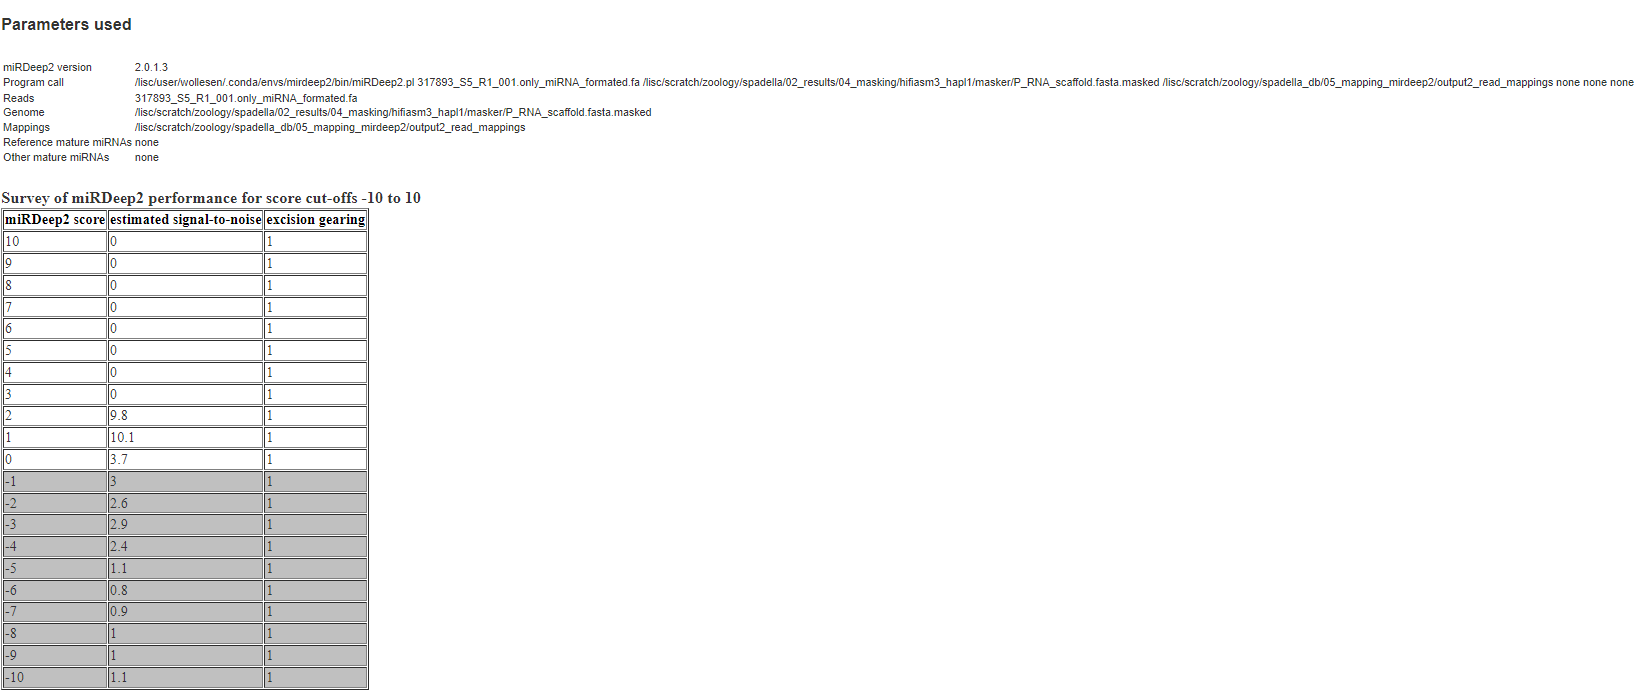

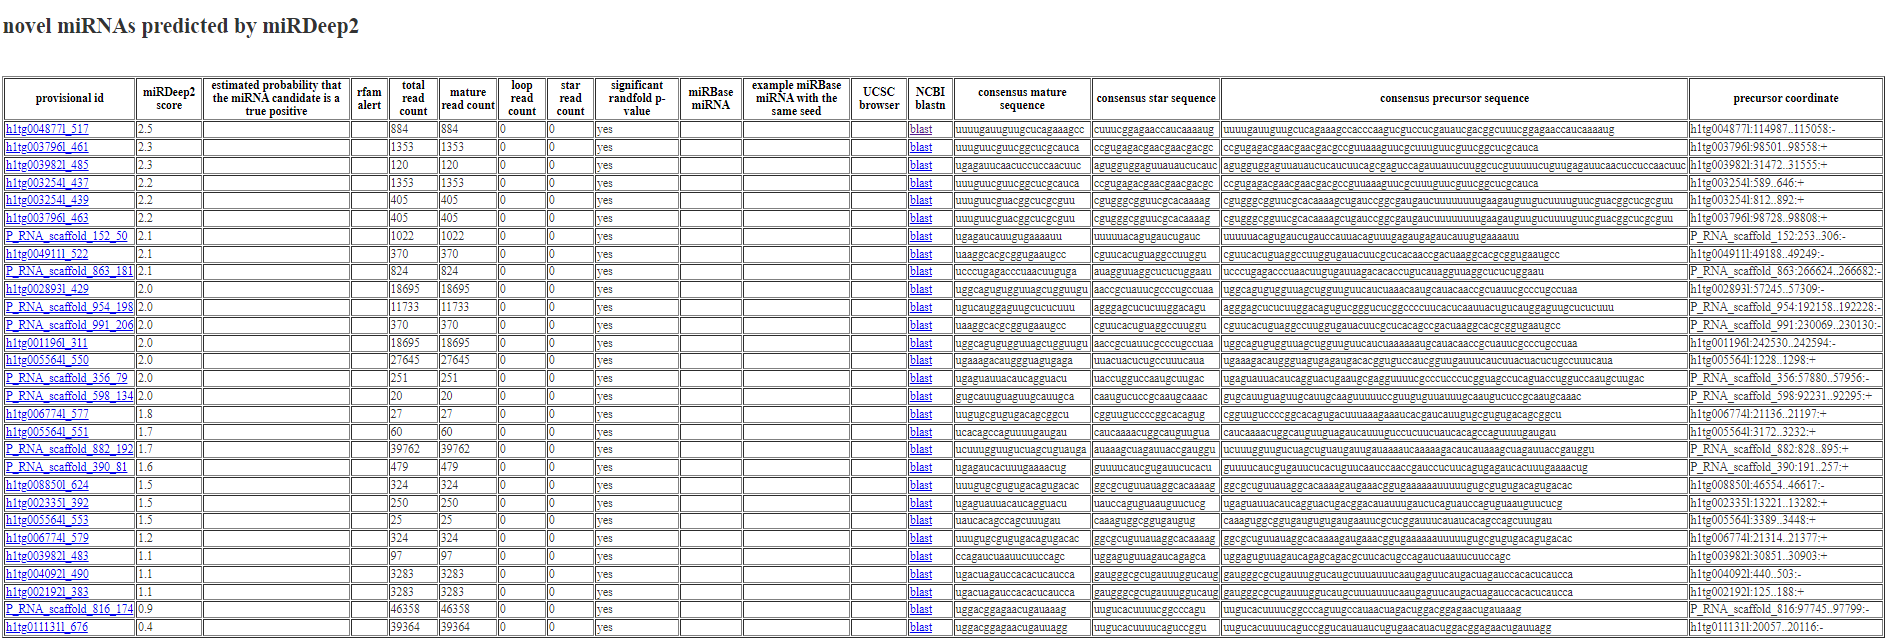

In addition, PDF files are produced for each miRNA with the following information:
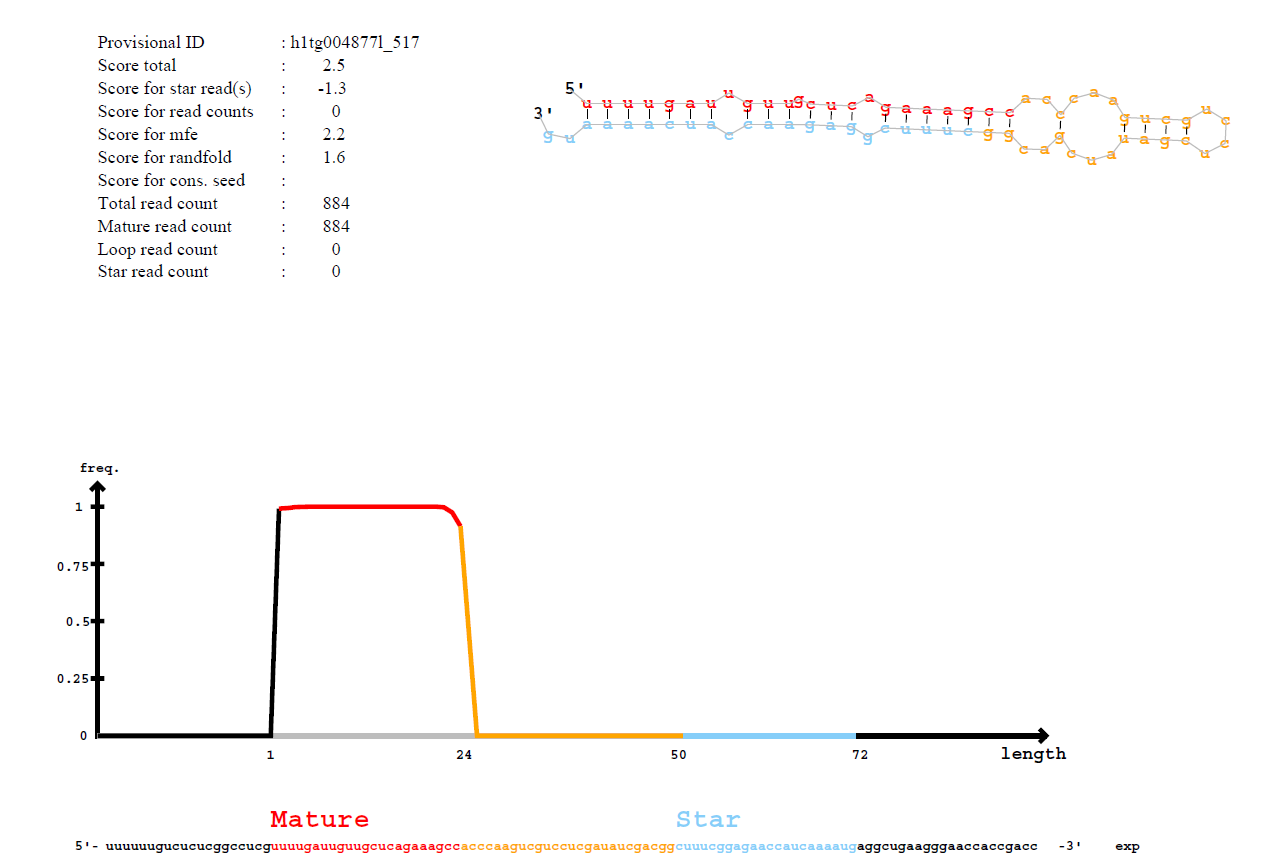

# Creating the gtf for the genome browser

With the output .csv from mirdeep2.pl we used mirdeep_gtf.py to generate out.gtf which can be used to visualize the entire precursor in the genome browser. (It prints a lot of stuff but it is ok as it was used for debugging)

In [ ]:
  GNU nano 5.6.1                                                                                                                                                                                                                                                                                                                       mirdeep_gtf.py
#!/usr/bin/env python3

import sys

def parse_coordinate(coord_string):
    """
    Attempt to parse a coordinate string in the format:
       'chrom:start..end:strand'
    Example: 'h1tg004877l:114987..115058:-'

    Returns: (chrom, start, end, strand)
    """
    print(f"DEBUG: parse_coordinate called with: {repr(coord_string)}")
    try:
        # Split at the first colon to separate 'chrom' from the remainder.
        chrom_part, rest = coord_string.split(':', 1)
        # The 'rest' should be something like '114987..115058:-'
        coords, strand = rest.split(':')
        start, end = coords.split('..')
        print(f"DEBUG: parse_coordinate parsed -> chrom={chrom_part}, start={start}, end={end}, strand={strand}")
        return chrom_part, start, end, strand
    except Exception as e:
        print(f"DEBUG: parse_coordinate failed for {repr(coord_string)}, error: {str(e)}")
        raise  # re-raise so the caller knows parsing failed

def convert_mirdeep2_novel_to_gtf(input_file, output_file):
    """
    Reads the combined CSV-like file containing:
      1) lines about 'miRDeep2 score  estimated signal-to-noise ...'
      2) line with 'novel miRNAs predicted by miRDeep2'
      3) header 'provisional id  miRDeep2 score ... precursor coordinate'
      4) actual data lines

    Writes a GTF to output_file.

    Debug statements are printed to show exactly why lines are skipped or processed.
    """

    SOURCE = "miRDeep2"
    FEATURE = "miRNA"
    FRAME = "."

    print(f"DEBUG: Starting conversion from {input_file} to {output_file}")
    try:
        with open(input_file, "r", encoding="utf-8") as infile, open(output_file, "w") as outfile:
            for line_num, line in enumerate(infile, start=1):
                # Show the raw line (with the trailing newline stripped).
                raw_line = line.rstrip('\n')
                print(f"\nDEBUG: [Line {line_num}] raw -> {repr(raw_line)}")

                # Strip leading/trailing whitespace for analysis
                line_stripped = raw_line.strip()
                print(f"DEBUG: [Line {line_num}] stripped -> {repr(line_stripped)}")

                # --- Skip Condition 1: empty line ---
                if not line_stripped:
                    print(f"DEBUG: [Line {line_num}] is empty, skipping.")
                    continue

                # --- Skip Condition 2: lines containing both "miRDeep2 score" and "excision gearing" ---
                # (This is for the top summary. Adjust if your file differs.)
                if "miRDeep2 score" in line_stripped and "excision gearing" in line_stripped:
                    print(f"DEBUG: [Line {line_num}] has 'miRDeep2 score' + 'excision gearing', skipping.")
                    continue

                # --- Skip Condition 3: line starts with "novel miRNAs predicted by miRDeep2" ---
                if line_stripped.startswith("novel miRNAs predicted by miRDeep2"):
                    print(f"DEBUG: [Line {line_num}] starts with 'novel miRNAs predicted by miRDeep2', skipping.")
                    continue

                # --- Skip Condition 4: line starts with "provisional id" (the table header) ---
                if line_stripped.startswith("provisional id"):
                    print(f"DEBUG: [Line {line_num}] starts with 'provisional id', skipping.")
                    continue

                # --- Skip Condition 5: line starts with "~" (sometimes a trailing line) ---
                if line_stripped.startswith("~"):
                    print(f"DEBUG: [Line {line_num}] starts with '~', skipping.")
                    continue

                # Now we split on whitespace to extract columns
                fields = line_stripped.split('\t')
                print(f"DEBUG: [Line {line_num}] split -> {fields} (count: {len(fields)})")

                # --- Skip Condition 6: fewer than 17 columns for the miRNA lines ---
                if len(fields) < 17:
                    print(f"DEBUG: [Line {line_num}] has fewer than 17 columns, skipping.")
                    continue

                # Retrieve relevant columns
                provisional_id = fields[0]
                mirdeep2_score = fields[1]
                coord_string = fields[16]

                print(f"DEBUG: [Line {line_num}] provisional_id={provisional_id}, "
                      f"mirdeep2_score={mirdeep2_score}, coord_string={coord_string}")

                # Parse the precursor coordinate
                try:
                    chrom, start, end, strand = parse_coordinate(coord_string)
                except Exception:
                    print(f"DEBUG: [Line {line_num}] coordinate parse failed, skipping.")
                    continue

                # Attempt to use the miRDeep2 score as numeric
                try:
                    float(mirdeep2_score)
                    score = mirdeep2_score
                    print(f"DEBUG: [Line {line_num}] using numeric score {score}")
                except ValueError:
                    score = "."
                    print(f"DEBUG: [Line {line_num}] score not numeric, using '.'")

                # Build GTF attributes (adjust if you want more fields)
                attributes_list = [
                    f'gene_id "{provisional_id}"',
                    f'transcript_id "{provisional_id}"',
                    f'miRDeep2_score "{mirdeep2_score}"'
                ]
                attributes_str = "; ".join(attributes_list) + ";"

                # Construct GTF line
                gtf_line = [
                    chrom,       # 1: seqname
                    SOURCE,      # 2: source
                    FEATURE,     # 3: feature
                    start,       # 4: start
                    end,         # 5: end
                    score,       # 6: score
                    strand,      # 7: strand
                    FRAME,       # 8: frame
                    attributes_str  # 9: attributes
                ]

                # Write to output
                outfile.write("\t".join(gtf_line) + "\n")
                print(f"DEBUG: [Line {line_num}] wrote GTF record -> {gtf_line}")

    except FileNotFoundError:
        print(f"ERROR: Could not open input file {input_file}", file=sys.stderr)
        sys.exit(1)

    print("DEBUG: Finished processing.")

if __name__ == "__main__":
    """
    Usage:
        python mirdeep2_novel_to_gtf_debug.py <input_file> <output_file>

    Example:
        python mirdeep2_novel_to_gtf_debug.py combined_data.csv novel_mirnas.gtf
    """
    if len(sys.argv) != 3:
        print(f"Usage: {sys.argv[0]} <input_file> <output_file>", file=sys.stderr)
        sys.exit(1)

    input_file = sys.argv[1]
    output_file = sys.argv[2]

    convert_mirdeep2_novel_to_gtf(input_file, output_file)
